# An Application of Logistic Regression in Finanical Data 
_We utilized logistic regression to analyze the stock price data and provided a predictive model._

Data source: Yahoo Finance

by Allan Lee, Jianhao Zhang, Yi Yan and Chengyu Tao (DSCI 522 Group 3 Milestone 1)

2023/11/17

In [1]:
#Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

#### Load and split the data

In [2]:
#import data and split into train and test
df = pd.read_csv("Data/Processed/data.csv", index_col=0)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df

,gspc,inflation_rate_pct,interest_rate_pct,inflation_rate_pct_chg,interest_rate_pct_chg,gspc_prev_year_pct_chg,gspc_next_year_pct_chg,target
date,,,,,,,,
2013-04-30,1597.569946,1.361965,0.150,-0.342289,0.000,14.282744,17.925976,True
1982-12-31,140.639999,3.711559,8.830,-4.679246,-3.470,14.761319,17.271042,True
1968-01-31,92.239998,3.951368,4.630,1.138868,-0.370,6.500401,11.676067,True
2005-04-30,1156.849976,2.802750,2.765,-0.249021,1.765,4.474842,13.291266,True
1986-02-28,226.919998,2.255639,7.830,-1.448065,-0.695,25.245616,25.242383,True
...,...,...,...,...,...,...,...,...
1963-09-30,71.699997,1.315789,3.500,-0.017544,0.500,27.421355,17.405863,True
1982-05-31,111.879997,7.064018,14.590,-2.488582,-3.900,-15.619579,45.146589,True
1987-05-31,290.100006,3.652968,6.750,1.887169,-0.090,17.283202,-9.631162,False


In [3]:
#Separate target value form train and test set 
X_train = train_df[['inflation_rate_pct', 'interest_rate_pct',
       'inflation_rate_pct_chg', 'interest_rate_pct_chg',
       'gspc_prev_year_pct_chg']]
y_train = train_df["target"]

X_test = test_df[['inflation_rate_pct', 'interest_rate_pct',
       'inflation_rate_pct_chg', 'interest_rate_pct_chg',
       'gspc_prev_year_pct_chg']]
y_test = test_df["target"]

In [4]:
sum(y_train)

461

In [5]:
len(y_train)-sum(y_train)

185

#### Data
The dataset comprises records for 808 months, with each row featuring a crucial predictor for the corresponding month. Additionally, it indicates whether there was an increase or decrease in the S&P 500 index, denoted by the values True or False.


#### Preprocessing Data

##### Numeric features:
- 'inflation_rate_pct'
- 'interest_rate_pct'
- 'inflation_rate_pct_chg'
- 'interest_rate_pct_chg'
- 'gspc_prev_year_pct_chg'

No missing values, we don't need to do imputation. And we apply a StandardScaler.

In [6]:
#Create pipeline for numeric features 
numeric_pipe = make_pipeline(
    StandardScaler()
)

In [8]:
numerical_features = ['inflation_rate_pct', 'interest_rate_pct',
       'inflation_rate_pct_chg', 'interest_rate_pct_chg',
       'gspc_prev_year_pct_chg']

#Create Column Transformer 
preprocessor = make_column_transformer(    
    (numeric_pipe, numerical_features),  
)

#### Model Selection
##### Logistic Regression
Our focus is on identifying whether there is an increase in the S&P 500 index, making it a classification problem. To tackle this, we utilize Logistic Regression. Given the significant imbalance in classes and our emphasis on minimizing false negatives, particularly crucial in medical contexts where we want to reduce instances of patients missing vital treatment, we incorporate the `class_weight` argument. Experimenting with various values for `class_weight`, we find that a ratio of 1:2 provides a satisfactory balance between recall and precision for our objectives.


In [9]:
pipe = make_pipeline(preprocessor, LogisticRegression(class_weight={0: 2, 1: 1}))

##### Hyperparameter Optimization
To identify the optimal model and prevent underfitting or overfitting, we aim to enhance the hyperparameter C of the Logistic Regression through Gridsearch.

In [10]:
# Create a grid search object to fine tune c
param_grid = {
  "logisticregression__C": 10.0 ** np.arange(-4, 6, 1),
}
gs = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1, return_train_score=True)
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['inflation_rate_pct',
                                                                          'interest_rate_pct',
                                                                          'inflation_rate_pct_chg',
                                                                          'interest_rate_pct_chg',
                                                                          'gspc_prev_year_pct_chg'])])),
                                       ('logisticregression',
                                        LogisticRegression(class_weight={0: 2,
                                                                         1: 1}))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04, 1.e+05])},
             return_train_score=True)

In [18]:
gs_res = pd.DataFrame(gs.cv_results_)[[
    'rank_test_score', 'param_logisticregression__C', 
    'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']].sort_values('rank_test_score').head(5)

In [19]:
gs.best_params_ #value for C: 1000

{'logisticregression__C': 0.01}

In [13]:
gs.best_score_

0.7182707215265355

##### Applying on test data

In [14]:
gs.score(X_test, y_test)

0.7345679012345679

The test data yields an accuracy of 73.4%. Accuracy is a metric calculated as the ratio of correct predictions to all predictions. This means that in 73.4% of our test instances, the target is predicted correctly, which appears satisfactory. Nevertheless, as previously noted, caution is necessary when interpreting this metric, particularly in the context of class imbalance.

##### Visualization of Confusion Matrix

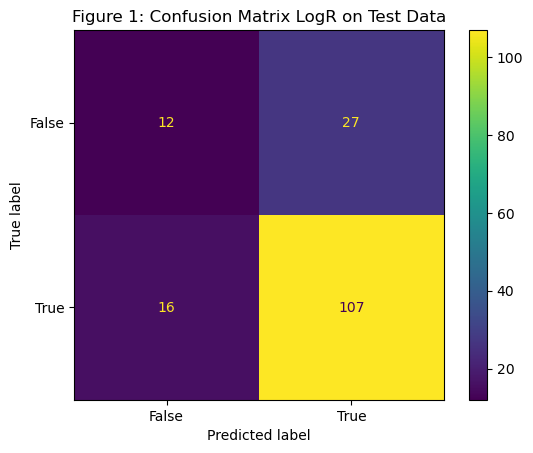

In [15]:
#Create a Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test,  # true class labels
    gs.predict(X_test),  # predicted class labels
)
plt.title('Figure 1: Confusion Matrix LogR on Test Data')
plt.show()

In [16]:
#Classification report for Test Data
print(
    classification_report(
        y_test, gs.predict(X_test)
    )
)

Table 2: Classification Report for Test Data
              precision    recall  f1-score   support

       False       0.43      0.31      0.36        39
        True       0.80      0.87      0.83       123

    accuracy                           0.73       162
   macro avg       0.61      0.59      0.60       162
weighted avg       0.71      0.73      0.72       162



The visual representation and the classification report indicate a notably high recall score of 0.87, which is favorable in our context. Conversely, the precision score, standing at 0.80, is also desirable for our scenario. With an accuracy value of 0.73, the overall performance seems acceptable.

#### Conclusion
In the preceding examination, we utilize `Logistic Regression`. It's crucial to highlight that the models exhibit suboptimal performance in terms of accuracy scores. Consequently, it becomes essential for future analyses to thoroughly investigate the individual features, scrutinizing their impact on predictions, or to undertake further data preprocessing to enhance the overall effectiveness of the model.